In [92]:
# imports

import os
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import random
import keras
import pickle

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split

# For reproducibility
np.random.seed(42)

%matplotlib inline

In [3]:
!pwd

/c/Users/Bruno/Documents/Data_Science/Submissions/Projects/Capstone


In [2]:
# Read in the CSV with photo_ids and labels
# 'food': 0, 'inside': 1, 'drink': 2, 'outside': 3, 'menu': 4

photos = pd.read_csv('../../../data/yelp/photos_with_labels.csv') # this is for my laptop's path

# photos = pd.read_csv('../../../data/photos_with_labels.csv') # desktop path

In [3]:
# Sort the dataframe to be alphabetical by the photo_id (file name)

photos.sort_values(by = 'photo_id', inplace = True)
photos.reset_index(inplace = True)
photos.drop('index', axis = 1, inplace = True)
photos.head()

,photo_id,label
0,--3uF9gf2WttniseRLlI6g.jpg,1
1,--4v2HCSXi092RwfidxlMg.jpg,0
2,--5FyXiUudlvrJyUCvpZJA.jpg,0
3,--6kOAkha3ULjhhw32KN1w.jpg,2
4,--8aLa0rf2gfOjA6kCC3WQ.jpg,1


In [4]:
# Set the main directory which our photos will come from

main_dir = '../../../data/yelp/photos/'
images = os.listdir(main_dir)
print(len(images))

200000


In [5]:
images[0]

'--3uF9gf2WttniseRLlI6g.jpg'

In [6]:
photos.head()

,photo_id,label
0,--3uF9gf2WttniseRLlI6g.jpg,1
1,--4v2HCSXi092RwfidxlMg.jpg,0
2,--5FyXiUudlvrJyUCvpZJA.jpg,0
3,--6kOAkha3ULjhhw32KN1w.jpg,2
4,--8aLa0rf2gfOjA6kCC3WQ.jpg,1


In [54]:
# Only needed this once - after saving it becomes redundant

# photos['photo_id'] = photos['photo_id'] + '.jpg'

In [55]:
photos.head()

,photo_id,label
0,--3uF9gf2WttniseRLlI6g.jpg,1
1,--4v2HCSXi092RwfidxlMg.jpg,0
2,--5FyXiUudlvrJyUCvpZJA.jpg,0
3,--6kOAkha3ULjhhw32KN1w.jpg,2
4,--8aLa0rf2gfOjA6kCC3WQ.jpg,1


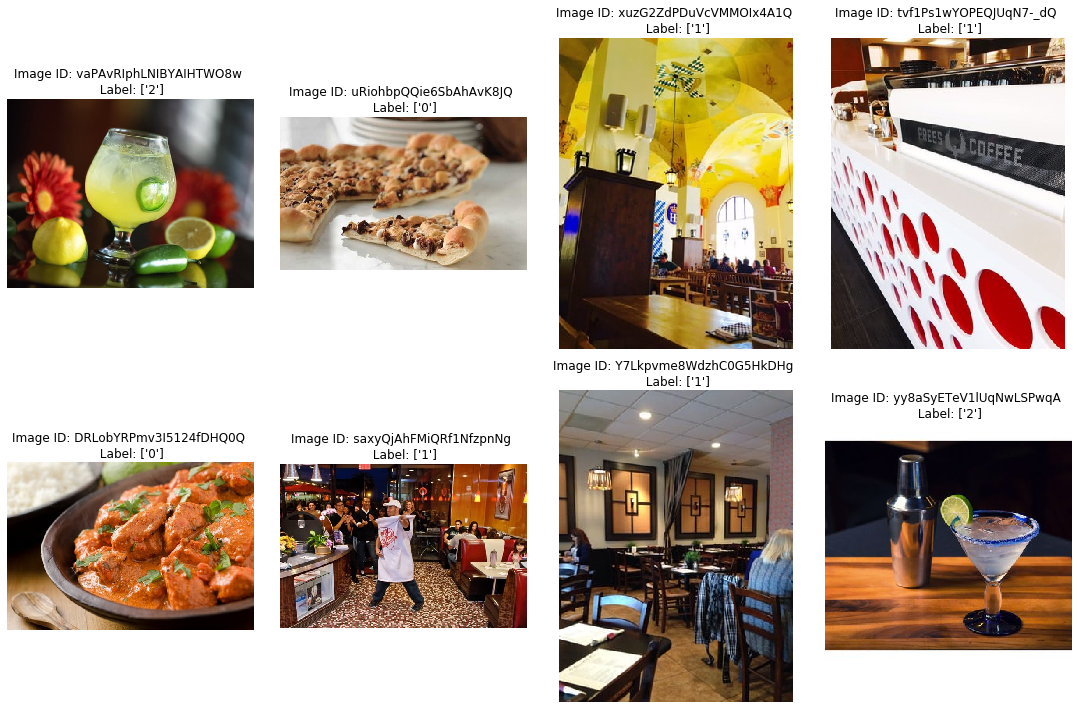

In [155]:
# Randomly sample 8 images
imgs_samples = random.sample(images, 8)

# Plot random sample of 8 images
plt.figure(figsize=(15, 10))
for i in range(len(imgs_samples)):
    # OpenCV2 reads images in BGR format
    img = cv2.imread(os.path.join(main_dir, imgs_samples[i]))
    # Switch color channels to RGB to make compatible with matplotlib imshow func
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # Grab image's photo ID and labels
    photo = imgs_samples[i][:-4]
    label = photos.loc[photos['photo_id'] == imgs_samples[i]]['label'].values
    # Annotate each image with image ID, and labels
    title = "Image ID: " + photo + '\nLabels: ' + label
    # Plot the image
    plt.subplot(2, 4, i+1)
    plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Image ID: {photo} \n Label: {label}")
plt.show()

In [38]:
def load_img_shapes(path_to_img):
    """ Return only the shape of an image (width, height, channels) """
    return cv2.imread(path_to_img).shape

In [39]:
# Initialize arrays to hold image sizes
image_shapes = []

# Load in training/testing image sizes
for i in range(len(images)):
    img_path = os.path.join(main_dir, images[i])
    image_shapes.append(load_img_shapes(img_path))

# Store training image sizes in dataframe
df_train = pd.DataFrame({'Shapes': image_shapes})
image_counts = df_train['Shapes'].value_counts()
# # Store testing image sizes in dataframe
# df_test = pd.DataFrame({'Shapes': test_shapes})
# test_counts = df_test['Shapes'].value_counts()

print("Image Shapes: First 100")
for i in range(100):
    print("Shape %s counts: %d" % (image_counts.index[i], image_counts.values[i]))
# print("*"*50)
# print("Testing Image Shapes: First 100")
# for i in range(100):
#     print("Shape %s counts: %d" % (test_counts.index[i], test_counts.values[i]))

Image Shapes: First 100
Shape (400, 533, 3) counts: 41654
Shape (400, 300, 3) counts: 29516
Shape (400, 600, 3) counts: 28915
Shape (400, 400, 3) counts: 22320
Shape (399, 600, 3) counts: 10126
Shape (337, 600, 3) counts: 8925
Shape (400, 534, 3) counts: 5291
Shape (400, 266, 3) counts: 5214
Shape (398, 600, 3) counts: 3100
Shape (400, 320, 3) counts: 2176
Shape (400, 225, 3) counts: 1802
Shape (397, 600, 3) counts: 1297
Shape (400, 598, 3) counts: 1010
Shape (400, 267, 3) counts: 965
Shape (400, 224, 3) counts: 898
Shape (400, 535, 3) counts: 799
Shape (291, 600, 3) counts: 631
Shape (150, 300, 3) counts: 600
Shape (400, 265, 3) counts: 545
Shape (400, 500, 3) counts: 491
Shape (400, 560, 3) counts: 359
Shape (400, 597, 3) counts: 358
Shape (400, 298, 3) counts: 330
Shape (336, 600, 3) counts: 322
Shape (300, 600, 3) counts: 309
Shape (400, 299, 3) counts: 303
Shape (400, 550, 3) counts: 277
Shape (338, 600, 3) counts: 276
Shape (396, 600, 3) counts: 252
Shape (324, 486, 3) counts: 23

In [61]:
# photos.to_csv('../../../data/yelp/photos_with_labels.csv', index = False)
# pics.to_csv('../../../data/yelp/pics_with_labels.csv')

In [67]:
# The labels need to be strings to pass through our Image Data Generator

photos['label'] = photos['label'].astype(str)

In [49]:
# Instantiate the Image Data Generators that we will use to generate the image data for our photos

datagen=ImageDataGenerator(featurewise_center=True,
                           featurewise_std_normalization=True,
                           rotation_range=20,
                           width_shift_range=0.1,
                           height_shift_range=0.1,
                           shear_range=16,
                           zoom_range=[0.9, 1.1],
                           fill_mode="constant",
                           cval=255,
                           horizontal_flip=True,
                           vertical_flip=True,
                           rescale=1./255.,
                           validation_split=0.25)

test_datagen = ImageDataGenerator(samplewise_center=True,
                                  samplewise_std_normalization=True,
                                  rotation_range=20,
                                  width_shift_range=0.1,
                                  height_shift_range=0.1,
                                  shear_range=16,
                                  zoom_range=[0.9, 1.1],
                                  fill_mode="constant",
                                  cval=255,
                                  horizontal_flip=True,
                                  vertical_flip=True,
                                  rescale=1./255.)

In [50]:
# Create train_generator, valid_generator, and test_generator for our dataset
# 142,500 training images, 47,500 validation images, 10,000 testing images

train_generator = datagen.flow_from_dataframe(
                                            dataframe=train,
                                            directory=main_dir,
                                            x_col="photo_id",
                                            y_col="label",
                                            subset="training",
                                            batch_size=100,
                                            seed=42,
                                            shuffle=True,
                                            class_mode="categorical",
                                            interpolation="bilinear",
                                            target_size=(256, 256))
valid_generator = datagen.flow_from_dataframe(
                                            dataframe=train,
                                            directory=main_dir,
                                            x_col="photo_id",
                                            y_col="label",
                                            subset="validation",
                                            batch_size=100,
                                            seed=42,
                                            shuffle=True,
                                            class_mode="categorical",
                                            interpolation="bilinear",
                                            target_size=(256, 256))

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test,
    directory=main_dir,
    x_col="photo_id",
    y_col="label",
    batch_size=1,
    seed=42,
    shuffle=True,
    class_mode="categorical",
    interpolation="bilinear",
    target_size=(256, 256)
)

Found 142500 validated image filenames belonging to 5 classes.
Found 47500 validated image filenames belonging to 5 classes.
Found 10000 validated image filenames belonging to 5 classes.


In [70]:
type(train_generator)

keras_preprocessing.image.dataframe_iterator.DataFrameIterator

In [76]:
# Check that our train generator files have the correct shape

train_generator[0][0][0].shape

(256, 256, 3)

In [77]:
# Create our first model - 2 Convolutional layers, 2 pooling layers, 2 fully connected dense layers, 2 dropout layers

model = Sequential()
model.add(Conv2D(filters = 16,
                 kernel_size = 3,
                 activation = 'relu',
                 input_shape = (256, 256, 3)))
model.add(MaxPooling2D(pool_size = 2))
model.add(Conv2D(64,
                 kernel_size = 3,
                 activation = 'relu'))
model.add(MaxPooling2D(pool_size = 2))

# We have to remember to flatten to go from the "box" to the vertical line of nodes!
model.add(Flatten())

# Add a densely-connected layer with 64 neurons.
model.add(Dense(64, activation='relu'))

# Let's try to avoid overfitting!
model.add(Dropout(0.3))

# Add a densely-connected layer with 32 neurons.
model.add(Dense(32, activation='relu'))

# Let's try to avoid overfitting!
model.add(Dropout(0.3))

# Add a final layer with 10 neurons.
model.add(Dense(5, activation='softmax'))

# Compile model
model.compile(loss='categorical_crossentropy',
                    optimizer='adam',
                    metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [80]:
# 5 epochs

history = model.fit_generator(train_generator,
                              steps_per_epoch = 300,
                              epochs= 5,
                              validation_data = valid_generator,
                              validation_steps = 100)

Instructions for updating:
Use tf.cast instead.
Epoch 1/5


C:\Users\bruno\Anaconda3\lib\site-packages\keras_preprocessing\image\image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\bruno\Anaconda3\lib\site-packages\keras_preprocessing\image\image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


300/300 [==============================] - 1731s 6s/step - loss: 1.0557 - acc: 0.6574 - val_loss: 0.8104 - val_acc: 0.7239
Epoch 2/5
300/300 [==============================] - 1684s 6s/step - loss: 0.8247 - acc: 0.7210 - val_loss: 0.7032 - val_acc: 0.7556
Epoch 3/5
300/300 [==============================] - 1742s 6s/step - loss: 0.7470 - acc: 0.7408 - val_loss: 0.7480 - val_acc: 0.7447
Epoch 4/5
300/300 [==============================] - 1631s 5s/step - loss: 0.6887 - acc: 0.7648 - val_loss: 0.7031 - val_acc: 0.7528
Epoch 5/5
300/300 [==============================] - 1716s 6s/step - loss: 0.6797 - acc: 0.7639 - val_loss: 0.6154 - val_acc: 0.7792


In [82]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 254, 254, 16)      448       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 127, 127, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 125, 125, 64)      9280      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 62, 62, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 246016)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                15745088  
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
__________

In [86]:
# Pickle will allow us to save our models
# As it turns out, Keras does not recommend using pickling for these models, and just saving them
# Using model.save(filename.h5)

import pickle

In [87]:
# Dump the model

with open('first_model.pkl', 'wb') as f:
    pickle.dump(model, f)

In [96]:
files = valid_generator.filenames

In [ ]:
preds = model.predict_generator(valid_generator, steps = len(files))

C:\Users\bruno\Anaconda3\lib\site-packages\keras_preprocessing\image\image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\bruno\Anaconda3\lib\site-packages\keras_preprocessing\image\image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


In [94]:
preds[0]

array([0.11528657, 0.5423335 , 0.14170645, 0.1560342 , 0.04463935],
      dtype=float32)

In [46]:
# Instantiate an ImageDataGenerator that does not rescale our images

nors_datagen=ImageDataGenerator(featurewise_center=True,
                           featurewise_std_normalization=True,
                           rotation_range=20,
                           width_shift_range=0.1,
                           height_shift_range=0.1,
                           shear_range=16,
                           zoom_range=[0.9, 1.1],
                           fill_mode="constant",
                           cval=255,
                           horizontal_flip=True,
                           vertical_flip=True,
                           validation_split=0.25)

nors_test_datagen = ImageDataGenerator(samplewise_center=True,
                                  samplewise_std_normalization=True,
                                  rotation_range=20,
                                  width_shift_range=0.1,
                                  height_shift_range=0.1,
                                  shear_range=16,
                                  zoom_range=[0.9, 1.1],
                                  fill_mode="constant",
                                  cval=255,
                                  horizontal_flip=True,
                                  vertical_flip=True)

In [47]:
nors_train_generator = nors_datagen.flow_from_dataframe(
                                            dataframe=train,
                                            directory=main_dir,
                                            x_col="photo_id",
                                            y_col="label",
                                            subset="training",
                                            batch_size=100,
                                            seed=42,
                                            shuffle=True,
                                            class_mode="categorical",
                                            interpolation="bilinear",
                                            target_size=(256, 256))
nors_valid_generator = nors_datagen.flow_from_dataframe(
                                            dataframe=train,
                                            directory=main_dir,
                                            x_col="photo_id",
                                            y_col="label",
                                            subset="validation",
                                            batch_size=100,
                                            seed=42,
                                            shuffle=True,
                                            class_mode="categorical",
                                            interpolation="bilinear",
                                            target_size=(256, 256))

nors_test_generator = nors_test_datagen.flow_from_dataframe(
    dataframe=test,
    directory=main_dir,
    x_col="photo_id",
    y_col="label",
    batch_size=1,
    seed=42,
    shuffle=True,
    class_mode="categorical",
    interpolation="bilinear",
    target_size=(256, 256)
)

Found 142500 validated image filenames belonging to 5 classes.
Found 47500 validated image filenames belonging to 5 classes.
Found 10000 validated image filenames belonging to 5 classes.


In [56]:
# Load in the individual datasets for each class

food = pd.read_csv('../../../data/yelp/food_with_labels.csv')
drinks = pd.read_csv('../../../data/yelp/drink_with_labels.csv')
inside = pd.read_csv('../../../data/yelp/inside_with_labels.csv')
outside = pd.read_csv('../../../data/yelp/outside_with_labels.csv')
menu = pd.read_csv('../../../data/yelp/menu_with_labels.csv')

In [67]:
# Create dataframes with 3,000 of each class

food3 = food.sample(3000, random_state = 42, axis = 0)
drinks3 = drinks.sample(3000, random_state = 42, axis = 0)
inside3 = inside.sample(3000, random_state = 42, axis = 0)
outside3 = outside.sample(3000, random_state = 42, axis = 0)
menu3 = menu.sample(3000, random_state = 42, axis = 0)

In [71]:
# Create a balanced dataframe with 3,000 of each class

balanced = pd.concat([food3, drinks3, inside3, outside3, menu3])
balanced.reset_index(inplace = True)
balanced.drop(columns = 'index', inplace = True)

In [72]:
balanced.head()

,photo_id,label
0,LIkl7V1jA4OtkzmHZuziVQ,0
1,uBN0wtj32rlmMDM-EK6dKw,0
2,TnYN9PbU8WCdHuVWWxHKgQ,0
3,ywQhU2n7MfCTYEzm1oef4Q,0
4,3Vjkfmv6IGeJyFuIiWMSyw,0


In [73]:
# Add .jpg to each file name

balanced['photo_id'] = balanced['photo_id'] + '.jpg'
balanced.head()

,photo_id,label
0,LIkl7V1jA4OtkzmHZuziVQ.jpg,0
1,uBN0wtj32rlmMDM-EK6dKw.jpg,0
2,TnYN9PbU8WCdHuVWWxHKgQ.jpg,0
3,ywQhU2n7MfCTYEzm1oef4Q.jpg,0
4,3Vjkfmv6IGeJyFuIiWMSyw.jpg,0


In [74]:
balanced['label'].value_counts()

4    3000
3    3000
2    3000
1    3000
0    3000
Name: label, dtype: int64

In [84]:
# Cast them as strings to pass through the ImageDataGenerator

balanced['label'] = balanced['label'].astype(str)

In [85]:
# Save our balanced CSV

balanced.to_csv('../../../data/yelp/balanced_dataset.csv', index = False)

In [86]:
# Train test split for model fitting purposes, keeping an even split of labels

bal_train, bal_test = train_test_split(balanced, test_size = 0.2, random_state = 42, stratify = balanced['label'])

In [103]:
bal_train['label'].value_counts()

4    2400
1    2400
3    2400
2    2400
0    2400
Name: label, dtype: int64

In [104]:
bal_test['label'].value_counts()

2    600
4    600
1    600
3    600
0    600
Name: label, dtype: int64

In [94]:
# Instantiate an ImageDataGenerator to pass our balanced dataframe through

balanced_datagen=ImageDataGenerator(samplewise_center=True,
                           samplewise_std_normalization=True,
                           rotation_range=20,
                           width_shift_range=0.1,
                           height_shift_range=0.1,
                           shear_range=16,
                           zoom_range=[0.9, 1.1],
                           fill_mode="constant",
                           cval=255,
                           horizontal_flip=True,
                           vertical_flip=True,
                           validation_split=0.25)

balanced_test_datagen = ImageDataGenerator(samplewise_center=True,
                                  samplewise_std_normalization=True,
                                  rotation_range=20,
                                  width_shift_range=0.1,
                                  height_shift_range=0.1,
                                  shear_range=16,
                                  zoom_range=[0.9, 1.1],
                                  fill_mode="constant",
                                  cval=255,
                                  horizontal_flip=True,
                                  vertical_flip=True)

In [95]:
# 9,000 training images, 3,000 validation images, 3,000 testing images

balanced_train_generator = nors_datagen.flow_from_dataframe(
                                            dataframe=bal_train,
                                            directory=main_dir,
                                            x_col="photo_id",
                                            y_col="label",
                                            subset="training",
                                            batch_size=100,
                                            seed=42,
                                            shuffle=True,
                                            class_mode="categorical",
                                            interpolation="bilinear",
                                            target_size=(256, 256))
balanced_valid_generator = nors_datagen.flow_from_dataframe(
                                            dataframe=bal_train,
                                            directory=main_dir,
                                            x_col="photo_id",
                                            y_col="label",
                                            subset="validation",
                                            batch_size=100,
                                            seed=42,
                                            shuffle=True,
                                            class_mode="categorical",
                                            interpolation="bilinear",
                                            target_size=(256, 256))

balanced_test_generator = nors_test_datagen.flow_from_dataframe(
    dataframe=bal_test,
    directory=main_dir,
    x_col="photo_id",
    y_col="label",
    batch_size=1,
    seed=42,
    shuffle=True,
    class_mode="categorical",
    interpolation="bilinear",
    target_size=(256, 256)
)

Found 9000 validated image filenames belonging to 5 classes.
Found 3000 validated image filenames belonging to 5 classes.
Found 3000 validated image filenames belonging to 5 classes.


In [97]:
bal_train_step = balanced_train_generator.n / balanced_train_generator.batch_size
bal_val_step = balanced_valid_generator.n / balanced_valid_generator.batch_size

In [98]:
# Create the balanced model
# 6 Convolutional layers, 3 Max Pooling layers, 2 fully connected dense layers, 2 dropout layers

balanced_model = Sequential()
balanced_model.add(Conv2D(filters = 16,
                     kernel_size = 3,
                     activation = 'relu',
                     input_shape = (256, 256, 3)))

balanced_model.add(MaxPooling2D(pool_size = 2))

balanced_model.add(Conv2D(32,
                     kernel_size = 3,
                     activation = 'relu'))

balanced_model.add(Conv2D(32,
                     kernel_size = 3,
                     activation = 'relu'))

balanced_model.add(MaxPooling2D(pool_size = 2))

balanced_model.add(Conv2D(64,
                     kernel_size = 3,
                     activation = 'relu'))

balanced_model.add(Conv2D(64,
                     kernel_size = 3,
                     activation = 'relu'))

balanced_model.add(MaxPooling2D(pool_size = 2))

balanced_model.add(Conv2D(128,
                     kernel_size = 3,
                     activation = 'relu'))

balanced_model.add(MaxPooling2D(pool_size = 2))

# We have to remember to flatten to go from the "box" to the vertical line of nodes!
balanced_model.add(Flatten())

# Add a densely-connected layer with 64 neurons.
balanced_model.add(Dense(64, activation='relu'))

# Let's try to avoid overfitting!
balanced_model.add(Dropout(0.3))

# Add a densely-connected layer with 32 neurons.
balanced_model.add(Dense(32, activation='relu'))

# Let's try to avoid overfitting!
balanced_model.add(Dropout(0.3))

# Add a final layer with 10 neurons.
balanced_model.add(Dense(5, activation='softmax'))

# Compile model
balanced_model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

In [99]:
# Fit the model, with an early stop after no improvement in 5 straight epochs

early_stop_5 = EarlyStopping(monitor = 'val_loss',
                           min_delta = 0,
                           patience = 5,
                           verbose = 1,
                           mode = 'auto')

bal_hist = balanced_model.fit_generator(balanced_train_generator,
                                        steps_per_epoch = bal_train_step,
                                        epochs= 50,
                                        validation_data = balanced_valid_generator,
                                        validation_steps = bal_val_step,
                                        callbacks = [early_stop_5])

Epoch 1/50
90/90 [==============================] - 842s 9s/step - loss: 9.0709 - acc: 0.2042 - val_loss: 1.6068 - val_acc: 0.2103
Epoch 2/50
90/90 [==============================] - 810s 9s/step - loss: 1.5345 - acc: 0.2887 - val_loss: 1.4330 - val_acc: 0.3580
Epoch 3/50
90/90 [==============================] - 811s 9s/step - loss: 1.4007 - acc: 0.3902 - val_loss: 1.2686 - val_acc: 0.4797
Epoch 4/50
90/90 [==============================] - 812s 9s/step - loss: 1.2914 - acc: 0.4644 - val_loss: 1.1306 - val_acc: 0.5583
Epoch 5/50
90/90 [==============================] - 812s 9s/step - loss: 1.2150 - acc: 0.5091 - val_loss: 1.1841 - val_acc: 0.5130
Epoch 6/50
90/90 [==============================] - 811s 9s/step - loss: 1.2239 - acc: 0.5042 - val_loss: 1.1225 - val_acc: 0.5737
Epoch 7/50
90/90 [==============================] - 811s 9s/step - loss: 1.1315 - acc: 0.5567 - val_loss: 1.1387 - val_acc: 0.5547
Epoch 8/50
90/90 [==============================] - 811s 9s/step - loss: 1.0814 - a

In [101]:
balanced_model.evaluate_generator(balanced_test_generator, steps = len(balanced_test_generator), verbose = 1)

3000/3000 [==============================] - 121s 40ms/step


[2.9705833360375835, 0.19433333333333333]

In [105]:
balanced_model.save('Models/balanced_model.h5')

# Evaluation

In [32]:
# Evaluate our models using confusions matrices and classification reports
from sklearn.metrics import confusion_matrix, classification_report

In [9]:
with open('3conv2densemodel15epoch.pkl', 'rb') as f:
    model1 = pickle.load(f)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


In [10]:
with open('3conv2densemodel_2_30epochs.pkl', 'rb') as f:
    model2 = pickle.load(f)

In [18]:
photos['label'] = photos['label'].astype(str)

In [78]:
train, test = train_test_split(photos, test_size = 0.05, random_state = 42, stratify = photos['label'])

In [79]:
train.shape

(190000, 2)

In [80]:
train.head()

,photo_id,label
11685,2kLHHZhvzRBcCkqrD8BvXQ.jpg,1
13882,3SYgJ2ttrvrkkZQVwBB9ZA.jpg,1
43353,Cv1ONeniReCw_1qi2cljtA.jpg,0
4756,0XjhceFCeCqM08OUm6Oniw.jpg,2
172017,r0cvTXkUdTk5AZ8fgvv6Cw.jpg,0


In [22]:
test.shape

(10000, 2)

In [23]:
test.head()

,photo_id,label
44587,DJfdb5ollatiIBcXhb_mVw.jpg,0
37985,BDk3HPd4srLRB34I6m794g.jpg,0
152320,kizRI9rvstjGs_6lyddxNA.jpg,3
4733,0X45rZJBrarNJnOk4sphqA.jpg,0
13497,3KUcJRrR_WYG7eAFZWGz0w.jpg,1


In [33]:
# With rescaled images

Y_pred = model1.predict_generator(test_generator, len(test_generator))
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(test_generator.classes, y_pred))
print('Classification Report')
target_names = ['Food', 'Inside', 'Drink', 'Outside', 'Menu']
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

Confusion Matrix
[[3510 1601  315  265   53]
 [1605  756  131  107   23]
 [ 552  275   45   29    5]
 [ 359  166   27   19    6]
 [  99   37    6    6    3]]
Classification Report
              precision    recall  f1-score   support

        Food       0.57      0.61      0.59      5744
      Inside       0.27      0.29      0.28      2622
       Drink       0.09      0.05      0.06       906
     Outside       0.04      0.03      0.04       577
        Menu       0.03      0.02      0.02       151

    accuracy                           0.43     10000
   macro avg       0.20      0.20      0.20     10000
weighted avg       0.41      0.43      0.42     10000



In [48]:
# With original images (not rescaled)

Y_pred = model1.predict_generator(nors_test_generator, len(nors_test_generator))
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(nors_test_generator.classes, y_pred))
print('Classification Report')
target_names = ['Food', 'Inside', 'Drink', 'Outside', 'Menu']
print(classification_report(nors_test_generator.classes, y_pred, target_names=target_names))

Confusion Matrix
[[3518 1636  310  229   51]
 [1583  773  123  116   27]
 [ 560  242   45   47   12]
 [ 334  174   37   25    7]
 [  80   48   11    9    3]]
Classification Report
              precision    recall  f1-score   support

        Food       0.58      0.61      0.60      5744
      Inside       0.27      0.29      0.28      2622
       Drink       0.09      0.05      0.06       906
     Outside       0.06      0.04      0.05       577
        Menu       0.03      0.02      0.02       151

    accuracy                           0.44     10000
   macro avg       0.20      0.20      0.20     10000
weighted avg       0.41      0.44      0.42     10000



In [34]:
Y_pred = model2.predict_generator(test_generator, len(test_generator))
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(test_generator.classes, y_pred))
print('Classification Report')
target_names = ['Food', 'Inside', 'Drink', 'Outside', 'Menu']
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

Confusion Matrix
[[3590 1488  390  196   80]
 [1616  690  173   99   44]
 [ 574  233   58   32    9]
 [ 360  138   41   28   10]
 [  89   43   10    7    2]]
Classification Report
              precision    recall  f1-score   support

        Food       0.58      0.62      0.60      5744
      Inside       0.27      0.26      0.26      2622
       Drink       0.09      0.06      0.07       906
     Outside       0.08      0.05      0.06       577
        Menu       0.01      0.01      0.01       151

    accuracy                           0.44     10000
   macro avg       0.20      0.20      0.20     10000
weighted avg       0.41      0.44      0.42     10000



In [51]:
Y_pred = model2.predict_generator(nors_test_generator, len(nors_test_generator))
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(nors_test_generator.classes, y_pred))
print('Classification Report')
target_names = ['Food', 'Inside', 'Drink', 'Outside', 'Menu']
print(classification_report(nors_test_generator.classes, y_pred, target_names=target_names))

Confusion Matrix
[[3540 1539  355  227   83]
 [1659  655  198   76   34]
 [ 542  260   69   21   14]
 [ 364  145   38   18   12]
 [ 100   34   10    4    3]]
Classification Report
              precision    recall  f1-score   support

        Food       0.57      0.62      0.59      5744
      Inside       0.25      0.25      0.25      2622
       Drink       0.10      0.08      0.09       906
     Outside       0.05      0.03      0.04       577
        Menu       0.02      0.02      0.02       151

    accuracy                           0.43     10000
   macro avg       0.20      0.20      0.20     10000
weighted avg       0.41      0.43      0.42     10000



In [35]:
with open('../../../first_model.pkl', 'rb') as f:
    first_mod = pickle.load(f)

In [36]:
Y_pred = first_mod.predict_generator(test_generator, len(test_generator))
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(test_generator.classes, y_pred))
print('Classification Report')
target_names = ['Food', 'Inside', 'Drink', 'Outside', 'Menu']
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

Confusion Matrix
[[4431 1305    8    0    0]
 [2010  610    2    0    0]
 [ 720  186    0    0    0]
 [ 442  133    2    0    0]
 [ 124   27    0    0    0]]
Classification Report
              precision    recall  f1-score   support

        Food       0.57      0.77      0.66      5744
      Inside       0.27      0.23      0.25      2622
       Drink       0.00      0.00      0.00       906
     Outside       0.00      0.00      0.00       577
        Menu       0.00      0.00      0.00       151

    accuracy                           0.50     10000
   macro avg       0.17      0.20      0.18     10000
weighted avg       0.40      0.50      0.44     10000



C:\Users\bruno\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [52]:
Y_pred = first_mod.predict_generator(nors_test_generator, len(test_generator))
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(nors_test_generator.classes, y_pred))
print('Classification Report')
target_names = ['Food', 'Inside', 'Drink', 'Outside', 'Menu']
print(classification_report(nors_test_generator.classes, y_pred, target_names=target_names))

Confusion Matrix
[[4412 1327    5    0    0]
 [2028  587    7    0    0]
 [ 696  209    1    0    0]
 [ 450  124    3    0    0]
 [ 116   35    0    0    0]]
Classification Report
              precision    recall  f1-score   support

        Food       0.57      0.77      0.66      5744
      Inside       0.26      0.22      0.24      2622
       Drink       0.06      0.00      0.00       906
     Outside       0.00      0.00      0.00       577
        Menu       0.00      0.00      0.00       151

    accuracy                           0.50     10000
   macro avg       0.18      0.20      0.18     10000
weighted avg       0.40      0.50      0.44     10000



C:\Users\bruno\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [43]:
model3 = keras.models.load_model('big_conv_model.h5')

In [54]:
Y_pred = model3.predict_generator(test_generator, len(test_generator))
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(test_generator.classes, y_pred))
print('Classification Report')
target_names = ['Food', 'Inside', 'Drink', 'Outside', 'Menu']
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

Confusion Matrix
[[3497 1557  332  277   81]
 [1592  733  133  134   30]
 [ 558  236   45   52   15]
 [ 332  155   43   36   11]
 [  79   50    8   10    4]]
Classification Report
              precision    recall  f1-score   support

        Food       0.58      0.61      0.59      5744
      Inside       0.27      0.28      0.27      2622
       Drink       0.08      0.05      0.06       906
     Outside       0.07      0.06      0.07       577
        Menu       0.03      0.03      0.03       151

    accuracy                           0.43     10000
   macro avg       0.20      0.21      0.20     10000
weighted avg       0.41      0.43      0.42     10000



In [55]:
Y_pred = model3.predict_generator(nors_test_generator, len(nors_test_generator))
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(nors_test_generator.classes, y_pred))
print('Classification Report')
target_names = ['Food', 'Inside', 'Drink', 'Outside', 'Menu']
print(classification_report(nors_test_generator.classes, y_pred, target_names=target_names))

Confusion Matrix
[[3481 1557  351  274   81]
 [1594  727  135  123   43]
 [ 545  242   61   46   12]
 [ 357  147   29   37    7]
 [  89   45    7    8    2]]
Classification Report
              precision    recall  f1-score   support

        Food       0.57      0.61      0.59      5744
      Inside       0.27      0.28      0.27      2622
       Drink       0.10      0.07      0.08       906
     Outside       0.08      0.06      0.07       577
        Menu       0.01      0.01      0.01       151

    accuracy                           0.43     10000
   macro avg       0.21      0.21      0.21     10000
weighted avg       0.41      0.43      0.42     10000



In [102]:
Y_pred = balanced_model.predict_generator(balanced_test_generator, len(balanced_test_generator))
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(balanced_test_generator.classes, y_pred))
print('Classification Report')
target_names = ['Food', 'Inside', 'Drink', 'Outside', 'Menu']
print(classification_report(balanced_test_generator.classes, y_pred, target_names=target_names))

Confusion Matrix
[[  0   0 576  24   0]
 [  0   0 574  26   0]
 [  0   0 570  30   0]
 [  0   0 571  29   0]
 [  0   0 568  32   0]]
Classification Report
              precision    recall  f1-score   support

        Food       0.00      0.00      0.00       600
      Inside       0.00      0.00      0.00       600
       Drink       0.20      0.95      0.33       600
     Outside       0.21      0.05      0.08       600
        Menu       0.00      0.00      0.00       600

    accuracy                           0.20      3000
   macro avg       0.08      0.20      0.08      3000
weighted avg       0.08      0.20      0.08      3000



C:\Users\bruno\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
